# Introduction

Welcome to the Reinforcement Learning Bachelor course!
This semester consists of 4 assignments, two of which are in the form of these Colab Notebooks. These first two assignments are relatively small and should provide a gentle introduction in 2 important topics underlying reinforcement learning.

- **A1A: Exploration**
- A1B: Dynamic Programming
- A2: Model-Free Reinforcement Learning
- A3: Model-Based Reinforcement Learning



## Assignment Requirements

The first two notebook assignments require you to read the Colab carefully, complete some (small) coding blocks within the notebook and write a report.

Throughout each notebook you will find questions that should provide inspiration for discussion points in your report. At the end of the notebook there will also be a summary of how the report should look like and what it should include.

#### What to hand in

1. This notebook, with code blocks completed.
    - Hand in the notebook **with** the results (primarily the plots) under each code cell; so do not delete the cell output before downloading the file.
    - Download this notebook file via "*File > Download > .ipynb Download*".
2. A small 1-2 page double-column report, created in latex using the template linked on [the website](https://irl.liacs.nl/assignments).

Hand in both the `ipynb` and the `pdf` as standalone files (**not as a ZIP file**) on brightspace before the due date.

Both assignment 1A and 1B should be accompanied by a standalone 1-2 page report. These can be handed in as seperate pdfs, or merged into a single file.

In [1]:
#@title Code Initialization
#@markdown <u>Please run this cell block before continuing. This code contains some plotting functions you will use throughout this notebook. You can inspect the code, but it is not required to fully understand it.</u>

# Plotting helper code -- run this cell before continuing.
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

class LearningCurvePlot:

    def __init__(self,title=None):
        self.fig,self.ax = plt.subplots()
        self.ax.set_xlabel('Time')
        self.ax.set_ylabel('Reward')
        self.ax.set_ylim([0,1.0])
        if title is not None:
            self.ax.set_title(title)

    def add_curve(self,y,label=None):
        ''' y: vector of average reward results
        label: string to appear as label in plot legend '''
        if label is not None:
            self.ax.plot(y,label=label)
            self.ax.legend()
        else:
            self.ax.plot(y)

    def save(self,name='test.png'):
        ''' name: string for filename of saved figure '''
        self.ax.legend()
        self.fig.savefig(name,dpi=300)


class ParamRangePlot:

    def __init__(self,title=None):
        self.fig,self.ax = plt.subplots()
        self.ax.set_xlabel('Parameter Value')
        self.ax.set_ylabel('Average Reward over first 1000 steps')
        self.ax.set_ylim([0,1.0])
        self.ax.set_xscale('log')
        self.ax.set_xlim([1/128, 8])
        if title is not None:
            self.ax.set_title(title)

    def add_curve(self,x,y,label=None):
        ''' y: vector of average reward results
        label: string to appear as label in plot legend '''
        if label is not None:
            self.ax.plot(x, y,label=label)
            self.ax.legend()
        else:
            self.ax.plot(x, y)

    def save(self,name='test.png'):
        ''' name: string for filename of saved figure '''
        self.ax.legend()
        self.fig.savefig(name,dpi=300)

def smooth(y, window, poly=1):
    '''
    y: vector to be smoothed
    window: size of the smoothing window '''
    return savgol_filter(y,window,poly)


# Assingment 1A - Exploration

This first assignment introduces the problem of **exploration**, a highly important, and actively researched, topic in reinforcement learning.

Reinforcement learning agents learn by performing actions. If we assume that these agents start with zero knowledge, they would need to start by performing some random actions to observe their outcomes and thereby gathering knowledge. However, we cannot keep acting randomly, as it would be very inefficient. Ideally, once we know that certain actions are bad, we no longer want to waste time in trying them again and instead want to focus on more promising actions. However, if an action lead to a bad results, can we be certain that it is a bad action? Perhaps we have just been unlucky, or it was earlier/follow-up action that caused a problem.

Hopefully you start to see the problem: we need to somehow balance **exploring** the unknown for long enough to be reasonably certain the observed outcomes are indeed the *true* outcome. Simultaniously, we do not want to waste too much time exploring bad actions, and instead should **exploit** the knowledge we have gained. This problem is known as the **exploration-vs-exploitation tradeoff** and is an ever-present issue in most learning tasks.

In this notebook, we will take a look at a few different methods of dealing with the **exploration-vs-exploitation tradeoff**. To do so, we will experiment in a simplified RL setting such that we can focus better on this single issue.
Later in the course, you will be able to transfer most of the knowledge gained here to the full RL setting.

## Introducing Bandits

Let's briefly recap an intuitive view on RL: An **Agent** observes some **environment state** $s \in \mathcal{S}$ and, based on this observation, decides on an **action** $a \in \mathcal{A}$. With this action and current state, the environment provides a next state and a **reward**. This loop continues until our environment terminates in some final state.

We can simplify by removing the time dimension from our problem, such that we have a "one-step" RL setting. That is, the environment terminates immediately after our first action and we only receive a (single) reward.
This is known as a **contextual bandit** and real-world examples could include recommender systems and advertisement placement.

We can simplify one step further by removing the context (observation/state). Perhaps unsurprisingly, this setting is known as a **bandit**. A bandit is equivalent to a contextual bandit where the agent always observes the same -- the observation contains no useful information to act on and the agent is acting "blind".


<img src='https://drive.usercontent.google.com/download?id=1-PfPJ1ytc7Q6t-bc-hnE9kEWv90ITIHd' />

(Contextual) bandits are named after the bandit/slot machines where we pull an arm (perform an action) and obtain some hidden reward. Sometimes, the term "multi-armed" bandit is used, because the agent does have multiple actions to choose.

Importantly, the observed rewards may be sampled from some probability distribution and we are generally interested in the **average reward** from this distribution. We can only approximate this average by sampling rewards from the same action multiple times. As such, we again face the **exploration-vs-exploitation tradeoff**. We want to explore each action sufficiently to get a good estimate of its *real* reward so that we find the actual best action. However, we need to balance this such that we waste as little actions as possible on bad (costly) actions.


<!-- A simplified problem would be a "one-step" RL setting. That is, the environment terminates immediately after our first action. Effectively, we have now removed the time dimension from our problem. We also hide the final state from the image below, since from a learning perspective, it is not relevant. -->

<!-- <img src='https://drive.usercontent.google.com/download?id=1--2F-4R4I5lcuPOmx0Hbwm9WEFtgrSr0' width="50%" /> -->

<!-- We can simplify even further by removing the observation. This is equivalent to the agent always observing the same -- the observation contains no useful information to act on. In this case, the agent is acting "blind". Essentially, we are now left with a set of actions, each of which leads **on average** to a specific reward. -->

<!-- <img src='https://drive.usercontent.google.com/download?id=1-31fD_vBHiSjA2WsTCGgN-bTGj-dTwLQ' width="50%" /> -->

<!-- This final setting is known as a **bandit**, as it is similar to a bandit/slot machine where we pull an arm (perform an action) and obtain some hidden reward. The second setting, where we do have relevant information in the observation is known as a **contextual bandit**.

Importantly, the hidden rewards may be sampled from some probability distribution and we are generally interested in the **average** rewards, which we can only approximate by sampling multiple times.
As such, we are now still left with a tradeoff between **exploration** and **exploitation**. We need to explore each action sufficiently enough to get a good estimate of its reward, but waste as little actions as possible because this may be costly. -->

<!-- #### An Example

Imagine an algorithm (agent) that recommends videos to users. The agent has access to the watch history of a user (observation) and has to pick one out of X videos to recommend as its action. Its reward is 1 if the user clicks and watches the recommended video, and 0 otherwise.

We can expect some videos to have a higher chance of success, but the bot initially has no clue which videos are good and has to **explore** various actions. If it finds that the first video (action 1) is not clicked, should it then assume that this is a bad action compared to all others? Perhaps the user would not have clicked any recommendation and the bot was just unlucky. As you may see, we require methods to deal with this tradeoff.

*Of course, real-world recommender systems are far more complex* -->

<!-- *** -->
<!--
As you may see, in this simplified setting we still have to deal with the exploration problem that we sketched out before. The agent may select "Advertisement X" and find that the user did not click on the ad. Should the agent now never try this ad again? Perhaps the user was just busy and would click on it some other time. -->

Next, we will create a simple bandit environment (without state information) and experiment with various techniques to address the exploration problem. Similar techniques can be used in the full reinforcement learning setting, which we will look at in later assignments.

## The Environment

The below code cell sets up a simple bandit environment with 10 actions and an assigned a random average reward to each action. The observed rewards of the environment (given by the `step()` function) are only 0 or 1, with the average reward dictating the chance that the reward will be 1.

In [2]:
import numpy as np

# For reproducibility
np.random.seed(42)

class BanditEnvironment():
    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.mean_rewards = np.random.uniform(low=0.0, high=1.0, size=n_actions)

    def step(self, action):
        ''' returns a sampled reward for the action '''
        return np.random.binomial(1, self.mean_rewards[action])

n_actions = 10
env = BanditEnvironment(n_actions=n_actions)

print(
    f"""
    Remember, the agent has no knowledge of the below values, but is tasked with finding its highest value through the `step` function.
    Average action rewards: {env.mean_rewards}
    Best Action: Action {np.argmax(env.mean_rewards)} with reward {np.max(env.mean_rewards)}
    """
)



    Remember, the agent has no knowledge of the below values, but is tasked with finding its highest value through the `step` function.
    Average action rewards: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258]
    Best Action: Action 1 with reward 0.9507143064099162
    


## The Agents

Here, we will first create two example agents and we provide an `experiment` function that you can reuse throughout this notebook.

The goal in any Bandit (or RL) agent is to train it such that the trained agent is able to select the best actions. Internally, an agent will select action by sampling from its action distribution, known as the **policy (π)**. The goal is then to obtain the best possible policy -- the optimal policy (denoted as $π^*$).
Often, we construct our agents policy implicitely by acting based on the agent's knowledge of prior actions. Conversely, bandit agents should store an estimate of the rewards for each action in some array. This estimate is called the Q-value and we initialize it to some arbitrary value (`self.Q = np.zeros(n_actions)`).
The training loop (`train()`) is then typically quite simple. As you can see in the function, we simply sample an action, observe the resulting reward, and update the agents knowledge (`self.Q`) with this new knowledge. This we simply repeat a number of times.

The first agent below, the `NaiveAgent` always exploits the current knowledge it has by simply selecting the action for which it estimates the highest reward (`action = np.argmax(self.Q)`). Always selecting the best-estimated action is known as the **greedy** policy. When the `NaiveAgent` observes a reward for any action, it stores the observed reward in its knowledge array (`self.Q`).
The second agent, the `RandomAgent` simply selects a random action each time.

You might expect both agents to perform pretty poorly, and you'd be right. However, please inspect and run the below code, as the structure of other agents will be similar. Furthermore, make sure you understand the `experiment()` function. Note that we repeat the experiment a large (500) amount of times. This is because, by pure chance, any agent may perform very well (or poor) on any randomly initialized environment. Scientifically, this is not desirable, so we repeat the experiment with varying seeds and average the results.

<!-- The idea in any type of Bandit (or RL) agent is to select an action by sampling from its internal action distribution, known as the **policy (π)**. Afterwards, the agent updates its knowledge about the resulting "goodness" of the performed action by storing it somehow. Naturally, all bandit agents store an estimate of the rewards for each action in some array. This estimate is called the Q-value and we initialize it to some arbitrary value (`self.Q = np.zeros(n_actions)`). Often, the Q-values are used to construct its policy -- the agent acts based on the knowledge it has acquired. -->





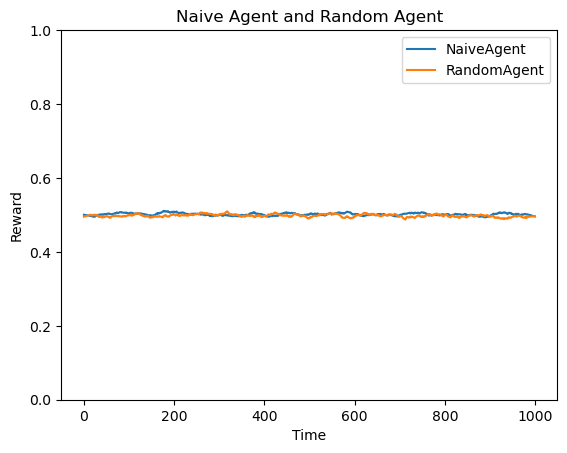

In [3]:
from abc import ABC

class Agent(ABC):
    def __init__(self, n_actions):
        # We initialize an estimated reward for each action and store this in an array.
        self.Q = np.zeros(n_actions)
        self.n_actions = n_actions

    def train(self, env, n_timesteps=1000):
        """
            Trains the current agent and returns the
            rewards obtained throughout training.
        """
        training_reward_curve = np.zeros(n_timesteps)
        for t in range(n_timesteps):
            action = self.select_action(t=t) # Provide the timestep index for some methods
            reward = env.step(action)
            self.update_Q(action, reward) # Update knowledge
            training_reward_curve[t] = reward
        return training_reward_curve

    def select_action(self, **kwargs):
        raise NotImplementedError("Implement this method in a subclass")

    def update_Q(self, action, observed_reward):
        raise NotImplementedError("Implement this method in a subclass")

class NaiveAgent(Agent):

    def select_action(self, **kwargs):
        """ Select an action """

        # Pick the action which has the highest estimated reward
        action = np.argmax(self.Q)
        return action

    def update_Q(self, action, observed_reward):
        """ After performing actions, update our current knowledge """

        # Set the new estimate to the reward we received after picking that action
        self.Q[action] = observed_reward

class RandomAgent(Agent):

    def select_action(self, **kwargs):
        """ Select an action """

        # Pick the action which has the highest estimated reward
        action = np.random.randint(self.n_actions)
        return action

    def update_Q(self, action, observed_reward):
        """ After performing actions, update our current knowledge """
        # We always act randomly, so no point in updating knowledge
        pass


def experiment(
        plot: LearningCurvePlot,
        agent_class,
        label,
        seed=42,
        **kwargs
    ):
    """
        Performs an experiment with a given agent class by
        repeatedly training a new agent instance on a new
        environment instance. Returns the average rewards
        over all repititions.
    """
    np.random.seed(seed) # For reproducibility

    n_repetitions = 500 # Repeat experiment 500 times to eliminate randomness
    n_timesteps = 1000 # We give the agent 1000 "learning" steps per repetition
    n_actions = 10

    rewards = np.zeros((n_repetitions, n_timesteps))
    for rep in range(n_repetitions):
        # New environment and agent every repetition !!
        agent = agent_class(n_actions, **kwargs)
        env = BanditEnvironment(n_actions=n_actions)
        rewards[rep] = agent.train(env, n_timesteps=n_timesteps)

    average_rewards = np.mean(rewards, axis=0) # average over the repetitions
    reward_curve = smooth(average_rewards, window=31)
    plot.add_curve(reward_curve, label=label)

def experiment_with_param_ranges(
    plot: ParamRangePlot,
    agent_class,
    label,
    param_name,
    param_values,
    seed=42,
    **kwargs):
    np.random.seed(seed) # For reproducibility

    n_repetitions = 500 # Repeat experiment 500 times to eliminate randomness
    n_timesteps = 1000 # We give the agent 1000 "learning" steps per repetition
    n_actions = 10

    avg_rewards_by_param = []

    for param_value in param_values:
        kwargs[param_name] = param_value
        rewards = np.zeros((n_repetitions, n_timesteps))
        for rep in range(n_repetitions):
            agent = agent_class(n_actions, **kwargs)
            env = BanditEnvironment(n_actions=n_actions)
            rewards[rep] = agent.train(env, n_timesteps=n_timesteps)
        avg_rewards = np.mean(rewards, axis=0)
        avg_rewards_by_param.append(np.mean(avg_rewards))

    plot.add_curve(param_values, avg_rewards_by_param, label=label)
    return avg_rewards_by_param

plot = LearningCurvePlot("Naive Agent and Random Agent")
for agent_class in [NaiveAgent, RandomAgent]:
    label = agent_class.__name__
    experiment(plot, agent_class, label=label)

***
Make sure you understand why these two agents perform the same (on average).
***

### Combining The Agents - ϵ-Greedy

A natural thing to do is to combine both above agents such that we use the knowledge we have obtained, but also (sometimes) explore other actions to see if they are better. If we do this in a specific manner, the policy of our new agent is known as an **ϵ-greedy policy**.

We leave parts of implementing the `ϵ-greedyAgent` up to you by completing the `select_action` function in the code block below. The idea here is that we want to select the best action (like the `NaiveAgent`) with some probability, while exploring a random action (like the `RandomAgent`) by some other probability. This probability is what we refer to as the epsilon ϵ value. Mathematically, we can formulate the select action function like below:

$$
    π_{ϵ-greedy}(a) =  
\begin{cases}
    1-ϵ, & \text{if } a = \text{argmax}_{b∈\mathcal{A}}Q(b) \\
    \frac{\epsilon}{|\mathcal{A}|-1},              & \text{otherwise}
\end{cases}
$$

Here, $π$ is the policy, $a$ an action, and $\mathcal{A}$ is the set of actions.

Once implemented, run the code block below to run experiments with varying ϵ values. You should obtain a plot with performance for each of the ϵ values.

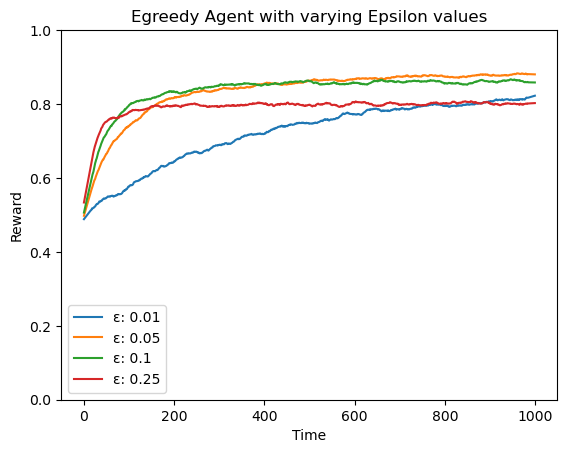

In [4]:
class eGreedyAgent(Agent):
    def __init__(self, n_actions, epsilon):
        super().__init__(n_actions) # Call parent class init

        self.epsilon = epsilon # <-- Egreedy specific values
        self.n = np.zeros(n_actions) # <-- Action counter

    def select_action(self, **kwargs):
        """ Select an action """

        if np.random.rand() < self.epsilon:
          action = np.random.randint(self.n_actions)
        else:
          action = np.argmax(self.Q)

        self.n[action] += 1
        return action

    def update_Q(self, action, observed_reward):
        """ After performing actions, update our current knowledge """

        # Set the new estimate to the reward we received after picking that action
        self.Q[action] = self.Q[action] + 1 / self.n[action] * (observed_reward - self.Q[action])

# You can use below values, or change them to ones that you find more interesting.
epsilon_values = [0.01, 0.05, 0.1, 0.25]

plot = LearningCurvePlot("Egreedy Agent with varying Epsilon values")
for epsilon in epsilon_values:
    experiment(
        plot,
        agent_class=eGreedyAgent,
        label=f"{chr(949)}: {epsilon}",
        epsilon=epsilon,
    )

Perhaps you have noticed that our `update_Q` function is not that great, as we are completely overwriting our estimate of an average to be the last reward that we have seen. Instead, it's better to "move" our estimate towards our latest observed reward via the incremental update:

$$
Q(a) \gets Q(a) + \frac{1}{n(a)} [r(a) - Q(a)],
$$
where $n$ counts how often we have tried action.

Adjust the `eGreedyAgent`'s `update_Q` function in the above code cell to the new update rule (and make sure you increment the counter $n$ as well). After doing so, rerun the code block to produce the performance plot. The agents should perform much better.

<!-- Instead, its better to incrementally update our estimate via the below formula's:

$$
n(a) \gets n(a) + 1,
$$

$$
Q(a) \gets Q(a) + \frac{1}{n(a)}[r(a) - Q(a)].
$$
Here, $n(a)$ is a simple counter tracking how often the agent has tried action $a$.  -->
<!--
Adjust the `eGreedyAgent`'s `update_Q` function in the above code cell and initialize the counter $n$ to 0 in the `__init__` function. Then rerun the experiment block. -->

***
Make sure you understand the egreedy policy formulation and the new update function. Discuss both in your report.
Include the resulting plot with the new update function in your report and discuss its results -- Why do you observe different results for the varying epsilon values? What would your recommendation be?
***

## Other Methods

We have seen the ϵ-greedy method and how it allows us to exploit current knowledge yet still explore new options. It is simple, yet very effective, and was even used in advanced methods developed by [Google to train reinforcement learning agents playing Atari games](https://arxiv.org/pdf/1312.5602).

ϵ-greedy is however not the only policy that ensures exploration -- we can define our policy in many different ways. We will take a look at two more methods.
1. **Optimistic Initialization (OI)**, which will demonstrate how we can leverage the initialization of `Q` for exploration;
2. **Upper Confidence Bounds (UCB)**, a more targeted method using uncertainty.



### Optimistic Initialization

Previously, we have initialized our Q-values at zero. The `OptimisticInitializationAgent` below will show how we can actually use different initialization values to benefit exploration. Complete the agent below, where the primary difference should be that we initialize our Q-values to values other than 0. Notably, in this implementation you can use the naive `select_action` method (without enforcing exploration), yet it will still manage to learn.

For the `update_Q` function, you can reuse the function from the previous agent. However, we can generalize the update function a bit to the following:
$$
Q(a) \gets Q(a) + α [r(a) - Q(a)],
$$
where α is the *step size* or *learning rate*. Rather than setting our learning rate to $\frac{1}{n(a)}$, we could also set it to a small positive value (like 0.1). Try both update rules to see which works better.

***
Select one of the update rules. Why do you think the other update rule failed in this agent?
Experiment with different `initial_values`. Which values make sense, and which do not? Include a plot containing multiple `initial_values` in your report to strengthen your reasoning.
***

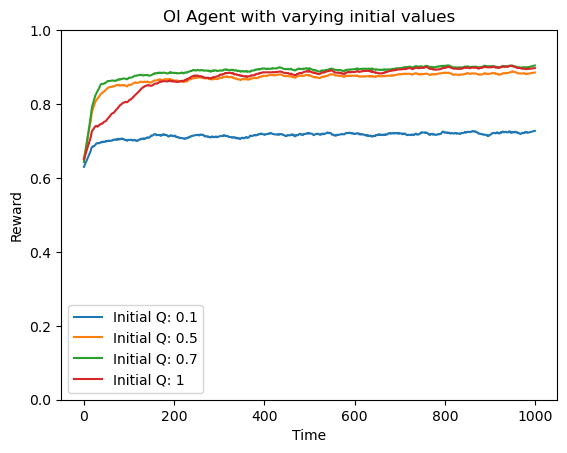

In [9]:
class OptimisticInitializationAgent(Agent):
    def __init__(self, n_actions, initial_value=0.0):
        super().__init__(n_actions) # Call parent class init
        self.n = np.zeros(n_actions) # <-- Action counter
        for index in range(len(self.Q)):
          self.Q[index] = initial_value

    def select_action(self, **kwargs):
        """ Select an action """

        # Naive (greedy) method -- leave as is
        # This is intended (although not strictly neccesary).
        # Reason why this still manages to learn
        action = np.argmax(self.Q)
        self.n[action] += 1
        return action

    def update_Q(self, action, observed_reward):
        """ After performing actions, update our current knowledge """
        a = 0.1
        self.Q[action] = self.Q[action] + a * (observed_reward - self.Q[action])
        # self.Q[action] = self.Q[action] + 1 / self.n[action] * (observed_reward - self.Q[action])


initial_values = [0.1, 0.5, 0.7, 1] # <--- Think of reasonable values to test here
if len(initial_values) == 0:
    raise NotImplementedError("Think of reasonable initial values to test and fill them in the initial_value list")

plot = LearningCurvePlot("OI Agent with varying initial values")
for initial_value in initial_values:
    experiment(
        plot,
        agent_class=OptimisticInitializationAgent,
        label=f"Initial Q: {initial_value}",
        initial_value=initial_value,
    )

### Upper Confidence Bounds (UCB)



The final `UCBAgent` uses uncertainty to explore in a more targeted manner. Complete the agent code below by implementing its `select_action` function and selecting an update rule. Then run the experiment to generate the plot. The policy can mathematically be formulated as:
$$
    π_{_{UCB}}(a) =  
\begin{cases}
    1, & \text{if } a = \text{argmax}_{b∈\mathcal{A}}[ Q(b) + c \cdot \sqrt{\frac{\ln(t)}{n(b)}} ] \\
    0,              & \text{otherwise},
\end{cases}
$$
where $t$ is the timestep, $c ∈ \mathbb{R}^{+}$ is the exploration constant, and $n$ is a counter tracking how often each action has been tried. **Importantly, when $n(a) = 0$, we treat the estimate for that action as infinity** (untried actions are always preferred over actions that have at least a single try).

***
Carefully inspects the UCB `action_select` function and the new update rule and make sure you understand both. What are its advantages and disadvantages?
***

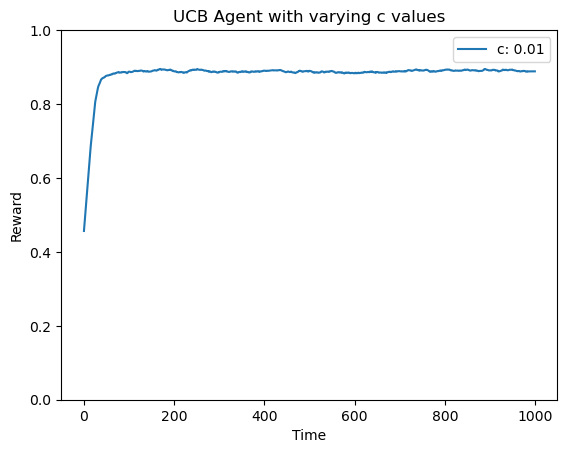

In [13]:
class UCBAgent(Agent):
    def __init__(self, n_actions, c):
        # We initialize an estimated reward for each action and store this in an array.
        self.Q = np.zeros(n_actions)
        self.n_actions = n_actions

        self.c = c
        self.n = np.zeros(n_actions) # Counter for how often actions are tried

    def select_action(self, t):
        """ Select an action """

        action_results = []
        for index in range(self.n_actions):
          if self.n[index] != 0:
            action_results.append(self.Q[index] + self.c * np.sqrt(np.log(t) / self.n[index]))
          else:
            action_results.append(np.inf)

        action = np.argmax(action_results)
        self.n[action] += 1
        return action

    def update_Q(self, action, observed_reward):
        """ After performing actions, update our current knowledge """

        self.Q[action] = self.Q[action] + 1 / self.n[action] * (observed_reward - self.Q[action])

c_list = [0.01]

plot = LearningCurvePlot("UCB Agent with varying c values")
for c in c_list:
    experiment(
        plot,
        agent_class=UCBAgent,
        label=f"c: {c}",
        c=c,
    )

## Comparison

You have now seen three different policies that address the exploration problem in the bandit setting. Use this last code block to create a comparison experiment. You are free to do so in any way you'd like as long as it creates a figure that you can insert into your report (see Figure 2.6 of [the book](http://incompleteideas.net/book/RLbook2020.pdf) (page 42) for an example). Of course, make sure you compare different methods fairly (For example, use the best configuration of each method). Also, consider what you are comparing. For example, some methods may achieve a better final performance but train much slower -- missing out on rewards in the process. Lastly, don't forget to do repeated experiments with different seeds (you can use the experiment function to do this for you).

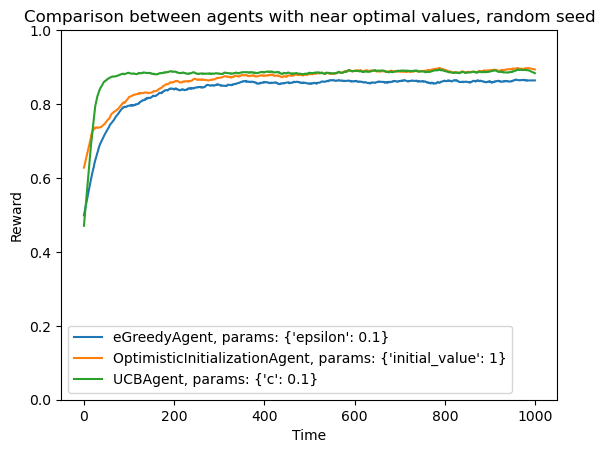

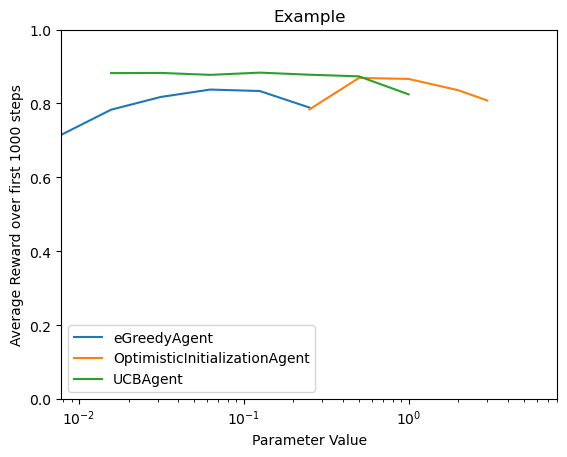

In [14]:
n_actions = 10
c_value = 0.1
initial_value = 1
epsilon = 0.1
plot = LearningCurvePlot("Comparison between agents with near optimal values, random seed")
seed = np.random.randint(0, 2**31-1)

agents = [
    (eGreedyAgent, {"epsilon": epsilon}),
    (OptimisticInitializationAgent, {"initial_value": initial_value}),
    (UCBAgent, {"c": c_value}),
]

plot2 = ParamRangePlot("Example")
epsilon_values = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]
oi_values = [1/4, 1/2, 1, 2, 3]
c_values = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]

agents2 = [
    (eGreedyAgent, "epsilon", epsilon_values, {"epsilon": epsilon}),
    (OptimisticInitializationAgent, "initial_value", oi_values, {"initial_value": initial_value}),
    (UCBAgent, "c", c_values, {"c": c_value})
]

for agent_class, param_name, param_values, params in agents2:
  label = f"{agent_class.__name__}, {param_name} values"
  experiment_with_param_ranges(plot2, agent_class, label=f"{agent_class.__name__}", param_name=param_name, param_values=param_values)

for agent_class, params in agents:
    experiment(
        plot,
        agent_class=agent_class,
        label=f"{agent_class.__name__}, params: {params}",
        seed=seed,
        **params,
    )


# Report Summary

Along with this notebook, you are to hand in a report (max 2 pages) discussing the different algorithms and results from this notebook. Some important notes on the report:

**General guidelines:**
- Assignment reports should be a standalone work. Instead of reading a solution to an assignment, the report should be structured and feel like a short academic paper. [The website](https://irl.liacs.nl/assignments) lists some example reports.
- Make sure you use the template linked on [the website](https://irl.liacs.nl/assignments)
- You can omit the abstract, but make sure you have a strong introduction: What is the paper about, why is that important, how are we tackling that problem etc.
- Going over the page limit (excluding references) will subtract 1 point per half page.
- Make sure to include some steps for future work. For example, can certain elements be combined? Be precise on how these next steps would look like.
- When displaying and discussing results, never only type down what we can all see in the figure/table. Instead, reason about your results. Explain why you think we observe them and what we can deduce.
- When an environment is involved, make sure this is (briefly) introduced to the reader.

**These items should be discussed in your report:**
- What are bandits (briefly)
- Discuss the exploration problem.
- Each of the three policies should be explained
    - Briefly touch on the different update rules
- Your report should at least contain 4 plots. One for each of the three policies and one comparison plot. The results in these plots should be discussed. Instead of only discussing what we can see in the plot, try to additionally reason **why** we observe certain results.
- Draw some conclusions near the end of your report. What have we learned from all the experiments, do you have certain recommendations?